In [18]:
import torch, os
from torch import Tensor, nn, optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from m_dataset import LandspaceDataset
from m_model import Recolorate
from m_utils import cosine_scheduler, sample_timesteps, noise_image

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
PATH = os.path.join('postprocessing')
W_SIZE = 128
H_SIZE = 128
BATCH = 4
SHUFFLE = True
STEPS = 1000
EMBEDDING = 256
EPOCHS = 10

transform = T.Compose([
  T.ToTensor(),
  T.RandomResizedCrop((W_SIZE, H_SIZE), (0.85, 1.0), interpolation=T.InterpolationMode.NEAREST),
  T.RandomHorizontalFlip(0.5),
])

dataset = LandspaceDataset(PATH, transform)
dataloader = DataLoader(dataset, BATCH, SHUFFLE, drop_last=True)

print('Dataset:', dataset)
print('Dataloader:', len(dataloader))

Dataset: <LandscapeDataset len:3924>
Dataloader: 981


In [3]:
model = Recolorate(STEPS, EMBEDDING, W_SIZE, H_SIZE, DEVICE).to(DEVICE)

In [5]:
model.load_state_dict(torch.load('model.pt', weights_only=True))

<All keys matched successfully>

In [14]:
#optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8)
loss_fn = nn.MSELoss()
scheduler = cosine_scheduler(STEPS, DEVICE)

In [19]:
total = 0
total_loss = 0

pbar = tqdm(total=len(dataloader), desc='Train', colour='yellow')
for original, gray in dataloader:
  original = original.to(DEVICE)
  gray = gray.to(DEVICE)

  t = sample_timesteps(BATCH, STEPS, DEVICE)
  sampled, noise = noise_image(original, t, scheduler, DEVICE)

  predicted = model(sampled, t, gray)
  loss:Tensor = loss_fn(noise, predicted)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  total_loss += loss.item() * original.shape[0]

  pbar.set_postfix(MSE=loss.item())
  pbar.update(1)

total_loss = total_loss / total
pbar.set_postfix(MSE=total_loss)
pbar.close()

Train:  80%|████████  | 789/981 [4:38:32<1:04:20, 20.11s/it, MSE=0.123] 

KeyboardInterrupt: 

In [22]:
torch.save(model.state_dict(), 'model.pt')

In [32]:
model
None

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 3/1000 [32:52<182:05:42, 657.52s/it]


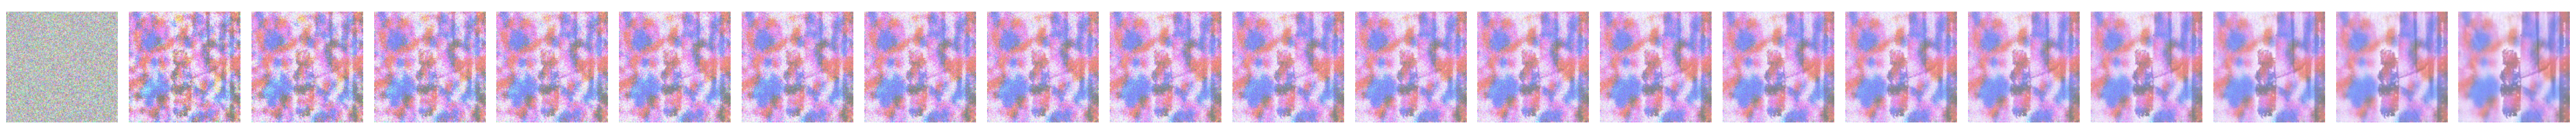

In [21]:
def plot_images(x:Tensor) -> Tensor:
  length = x.shape[0]
  plt.figure(figsize=(length*2, 1*2))
  plt.axis('off')
  for i in range(length):
    plt.subplot(1, length, 1+i)
    plt.axis('off')
    plt.imshow(x.detach().cpu()[i].swapaxes(0, -1).numpy())
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 1e-1)
  plt.show()

def distribution_to_image(x:Tensor, tag:str=''):
  x = torch.clone((x*dataset.std + dataset.mean).detach().cpu())
  x = (x.clamp(-1, 1) + 1) / 2
  x = (x * 255).type(torch.uint8)
  image = Image.fromarray(x[0].moveaxis(0, -1).numpy())
  image.save(f'output/img-{tag}.png')
  return x

def genereate_image_timesteps(model:Recolorate, scheduler:tuple[Tensor, Tensor, Tensor], src:Tensor, device='cpu'):
  alpha_, beta_, alpha_hat_ = scheduler

  generations = []

  model.eval()
  model.to(device)
  with torch.inference_mode():
    x = torch.randn((1, 3, 128, 128), device=device)
    generations.append(distribution_to_image(x, '0'))
    pbar = tqdm(total=1000, desc=f'Sampling', position=0, colour='yellow')
    pbar.update(1)

    for i in reversed(range(1, 1000)):
      t = (torch.ones(1, device=device) * i).long()
      predicted:Tensor = model(x, t, src)
      alpha = alpha_[t][:, None, None, None]
      alpha_hat = alpha_hat_[t][:, None, None, None]
      beta = beta_[t][:, None, None, None]
      if i > 1:
        noise = torch.randn_like(x, device=device)
      else:
        noise = torch.zeros_like(x, device=device)

      x = (1 / torch.sqrt(alpha)) * (x - (1-alpha) / torch.sqrt(1 - alpha_hat) * predicted) + torch.sqrt(beta)*noise
      x = x.clamp(-2.25, 2.25)

      if (i-1) % 50 == 0:
        generations.append(distribution_to_image(x, f'{1000-i+1}'))
      pbar.update(1)
    pbar.close()

  x = torch.cat(generations, dim=0)

  plot_images(x)

  return x

src = dataset[0][1].unsqueeze(0)
data = genereate_image_timesteps(model, scheduler, src, DEVICE)